In [1]:
import argparse
import pandas as pd
import datetime

In [2]:
import logging
from importlib import reload
# initiatie logging
reload(logging)
logging.basicConfig(
    #filename="{0}/{1}.log".format(logPath, fileName),
    format='%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s', 
    level=logging.DEBUG)
# to close file:
#logging.shutdown()

In [3]:
class plausibiliteit(object):
    def __init__(self):
        return

    def read_bui(self,filename):
        """
        parse een bui-file naar een dataframe
        Parameters
        ----------
        filename : str
            pad naar het .bui bestand
        
        Returns
        -------
        df : pandas.DataFrame
            dataframe met in de kolommen de neerslag in mm voor de stations
            en in de rijen de waarnemingstijdstappen
        """
        # initatie van lege immutable objects
        # zie: https://stackoverflow.com/a/22526544/2459096
        # python2.7: obj = argparse.Namespace()
        # python3.x: obj = types.SimpleNamespace()        
        self.buiFile = argparse.Namespace()
        with open(filename, 'r') as infile:
            f = infile.readlines()
            for i in range(len(f)):
                #print ('regel {0}'.format(str(i)))
                line = f[i]
                if line[0] == '*':
                    logging.info('regel {0} is comment'.format(str(i)))
                    if 'Gebruik de default dataset' in line:
                        self.buiFile.default_dataset = int(f[i+1])
                    if 'Aantal stations' in line:
                        self.buiFile.aantal_stations = int(f[i+1])
                    if 'Namen van stations' in line:
                        stations = f[i+1:i+1+self.buiFile.aantal_stations]
                        self.buiFile.stations = [station.rstrip().replace("'","") for station in stations]
                    if 'aantal seconden per waarnemingstijdstap' in line:
                        geb_sec = f[i+1].split()
                        self.buiFile.aantal_gebeurtenissen = int(geb_sec[0])
                        self.buiFile.aantal_seconden = int(geb_sec[1])
                    if 'Het format is: yyyymmdd:hhmmss:ddhhmmss':
                        T0_raw = f[i+1]#.split()                
                        idx_block = i
            # get data block
            # voor elk station de neerslag in mm per tijdstap
            s = pd.Series(f[idx_block+2:len(f)-1])

        # parse datablock to DataFrame
        df = s.str.rstrip().str.lstrip().str.split(' +', expand=True)
        df = df.apply(pd.to_numeric)            

        # startdatum en -tijd
        T0_str = T0_raw.rstrip().lstrip().split()
        # Het format is: yyyymmdd:hhmmss
        self.buiFile.start_datum        = datetime.datetime(*list(map(int,T0_str[0:6])))
        # lengte van de gebeurtenis in dd hh mm ss
        lengte_gebeurtenis = list(map(int,T0_str[6::]))
        self.buiFile.delta_dag          = lengte_gebeurtenis[0]
        self.buiFile.delta_uur          = lengte_gebeurtenis[1]
        self.buiFile.delta_minuut       = lengte_gebeurtenis[2]
        self.buiFile.delta_seconde      = lengte_gebeurtenis[3]

        # date_range gebeurtenis
        gebeurtenis_date_range = pd.date_range(
            start=self.buiFile.start_datum, 
            end=None, 
            periods=df.shape[0], 
            freq='{0}S'.format(self.buiFile.aantal_seconden)
        )

        df.set_index(gebeurtenis_date_range, inplace=True)
        df.columns = self.buiFile.stations    

        return df
pb = plausibiliteit()

In [4]:
bui_file = r'D:\Projects\Pr\3651.10\Toeleveringen\23082017_AnneJoepen_e-mail\WSA29.lit\Fixed\P798.bui'
df = pb.read_bui(bui_file)

2017-11-07 23:52:23,359 [MainThread  ] [INFO ]  regel 0 is comment
2017-11-07 23:52:23,365 [MainThread  ] [INFO ]  regel 1 is comment
2017-11-07 23:52:23,367 [MainThread  ] [INFO ]  regel 2 is comment
2017-11-07 23:52:23,368 [MainThread  ] [INFO ]  regel 3 is comment
2017-11-07 23:52:23,369 [MainThread  ] [INFO ]  regel 5 is comment
2017-11-07 23:52:23,371 [MainThread  ] [INFO ]  regel 7 is comment
2017-11-07 23:52:23,372 [MainThread  ] [INFO ]  regel 95 is comment
2017-11-07 23:52:23,374 [MainThread  ] [INFO ]  regel 96 is comment
2017-11-07 23:52:23,375 [MainThread  ] [INFO ]  regel 98 is comment
2017-11-07 23:52:23,376 [MainThread  ] [INFO ]  regel 99 is comment
2017-11-07 23:52:23,378 [MainThread  ] [INFO ]  regel 100 is comment
2017-11-07 23:52:23,379 [MainThread  ] [INFO ]  regel 101 is comment


In [5]:
pb.buiFile.start_datum

datetime.datetime(2012, 12, 31, 23, 0)

In [6]:
# resample to monthy sumations for plotting purposes without overflow 
result = df.resample('1m').sum()

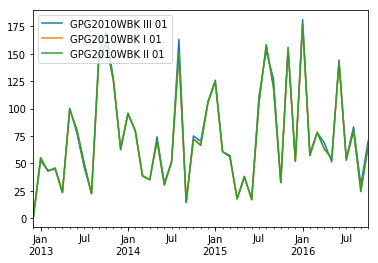

In [7]:
%matplotlib inline
result.iloc[:,0:3].plot()

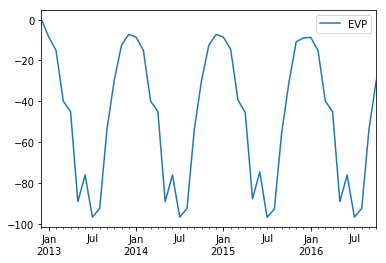

In [8]:
result.loc[:,pb.buiFile.stations[-1]].plot(legend=True)